In [1]:
%load_ext autoreload
%autoreload 2

from glob import glob
import matplotlib.pyplot as plt 
import os
import pandas as pd

from mocca.campaign.model import HplcDadCampaign
from mocca.campaign.process_funcs import process_compound_experiments
from mocca.campaign.settings import Settings
from mocca.campaign.user_objects import Experiment
from mocca.campaign.user_objects import Compound
from mocca.campaign.user_objects import InternalStandard

from mocca.dad_data.models import CompoundData, GradientData

from mocca.peak.models import CorrectedPeak
from mocca.decomposition.parafac_funcs import parafac
from mocca.peak.resolve_impure import get_parafac_peaks

from mocca.report.experiments import report_experiments
from mocca.report.peaks import report_peaks
from mocca.report.quali_comps import report_quali_comps
from mocca.report.quant_comps import report_quant_comps
from mocca.report.gradient import report_gradient
from mocca.report.chroms import report_chroms
from mocca.report.parafac import report_parafac
from mocca.report.results import report_runs

In [21]:
report_path = r"/Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports"
report_experiments(campaign.experiments, report_path)
report_peaks(campaign.peak_db, report_path)
report_quali_comps(campaign.quali_comp_db, report_path)
report_quant_comps(campaign.quant_comp_db, report_path)
report_gradient(campaign.gradient, report_path)
report_chroms(campaign.chroms, campaign.settings, report_path)
report_parafac(campaign.chroms, report_path)
report_runs(campaign.chroms, campaign.quali_comp_db, campaign.quant_comp_db, report_path)

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_experiments.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_peak_db.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_quali_comp_db.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_quant_comp_db.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_gradient.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_chroms.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

How is your experience of Datapane? Please take two minutes to answer our anonymous product survey <a href='https://bit.ly/3lWjRlr' target='_blank'>here</a>

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_parafac.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_runs.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

In [17]:
report_path = r"/Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports"
report_parafac(campaign.chroms, report_path)

Report saved to .//Users/haascp/Documents/GitHub/mocca/src/mocca/report/example_reports/report_parafac.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

In [24]:
campaign.chroms

In [2]:
# get the folders matching flag in directory
flag = '.txt'

###
# Add the path to the provided data folder
test_data_path = '/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data' # directory of test data
###

folders = glob(test_data_path + '/*' + flag + '*') #find all matching flag
folders = sorted(folders, key=lambda x: int(x.split('_')[-1][:-4]))

In [3]:
istd_folder = [folder for folder in folders if folder.split('_')[-1][:-4] == '96']

product_indices =['92', '93', '94', '95']
product_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in product_indices]

substrate_indices =['88', '89', '90', '91']
substrate_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in substrate_indices]

# obviously, we used a blank injection as the gradient run
gradient_folder = [folder for folder in folders if folder.split('_')[-1][:-4] == '97']

In [4]:
# remove some data which was gathered due to repeated start of the campaigns
bad_indices =['0', '1', '2', '3']
bad_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in bad_indices]

cnsource_indices =['98', '99']
cnsource_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in cnsource_indices]

remove_folders = bad_folders + istd_folder + product_folders + substrate_folders + gradient_folder + cnsource_folders

reaction_folders = [folder for folder in folders if folder not in remove_folders]

In [5]:
gradient_experiment = Experiment(gradient_folder[0], gradient=True)

In [6]:
campaign = HplcDadCampaign('labsolutions')

In [7]:
ArCl_concs = [0.0603, 0.04422, 0.03015, 0.01407]
ArCN_concs = [0.05955, 0.04367, 0.029775, 0.013895]
istd_conc = 0.06094

In [8]:
istd_experiment = Experiment(istd_folder[0], compound=Compound('tetralin', istd=True))

In [9]:
substrate_experiments = []
for i, conc in enumerate(ArCl_concs):
    exp = Experiment(substrate_folders[i], compound=Compound('2-chlorotoluene', conc), istd=InternalStandard('tetralin', istd_conc))
    substrate_experiments.append(exp)

In [10]:
product_experiments = []
for i, conc in enumerate(ArCN_concs):
    exp = Experiment(product_folders[i], compound=Compound('o-tolunitrile', conc), istd=InternalStandard('tetralin', istd_conc))
    product_experiments.append(exp)

In [11]:
parafac_dev_folder = reaction_folders[78]
parafac_debug_folder = reaction_folders[70]
parafac_impure_istd = reaction_folders[35]

In [12]:
parafac_impure_istd

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_39.txt'

In [16]:
reaction_experiments = [Experiment(folder, istd=InternalStandard('tetralin', istd_conc)) for folder in reaction_folders]
#reaction_experiments = [Experiment(parafac_dev_folder, istd=InternalStandard('tetralin', istd_conc))]
#reaction_experiments = [Experiment(parafac_debug_folder, istd=InternalStandard('tetralin', istd_conc))]
#reaction_experiments = [Experiment(parafac_impure_istd, istd=InternalStandard('tetralin', istd_conc))]

In [14]:
campaign.add_experiment(gradient_experiment)
campaign.add_experiment(istd_experiment)
for exp in product_experiments:
    campaign.add_experiment(exp)
for exp in substrate_experiments:
    campaign.add_experiment(exp)
for exp in reaction_experiments:
    campaign.add_experiment(exp)

In [20]:
campaign.process_all_experiments(detector_limit=campaign.settings.detector_limit, wl_low_pass=None,
                                 spectrum_correl_thresh=0.99, relative_distance_thresh=0.01,
                                 wl_high_pass = 215, peaks_high_pass = 1,
                                 peaks_low_pass = 5, absorbance_threshold = 200)

/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_4.txt
/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_5.txt
/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_6.txt
/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_7.txt
/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_8.txt
/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_9.txt
/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_10.txt
/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_11.txt
/Users/haascp/Document

In [31]:
impure_peak = next(peak for peak in campaign.chroms[-1] if not peak.pure)

----- new PARAFAC decomposition with iteration offset -3 -----
new data tensor with boundaries (1280, 1391) and shape(5,) built from ['2-chlorotoluene'].
PARAFAC data tensor has boundaries in the time axis of (1280, 1391).
Compound used for PARAFAC data tensor: 2-chlorotoluene


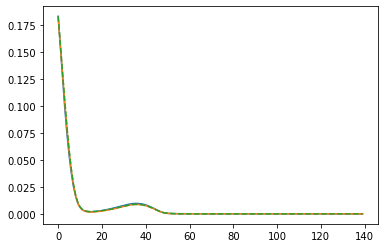

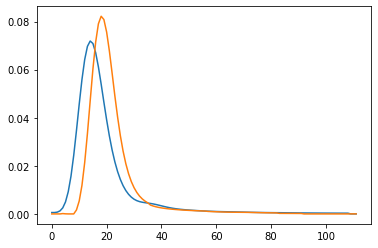

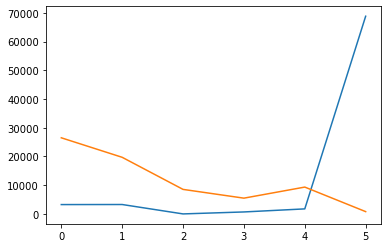

integral_array = [[ 3252.49375797 26511.39266746]
 [ 3274.69648435 19717.23948731]
 [    0.          8540.10823914]
 [  685.73673439  5489.96243843]
 [ 1751.2645199   9345.31854134]
 [68843.14238647   798.56310514]]
----- new PARAFAC decomposition with iteration offset -2 -----
new data tensor with boundaries (1280, 1390) and shape(5,) built from ['2-chlorotoluene'].
PARAFAC data tensor has boundaries in the time axis of (1280, 1390).
Compound used for PARAFAC data tensor: 2-chlorotoluene


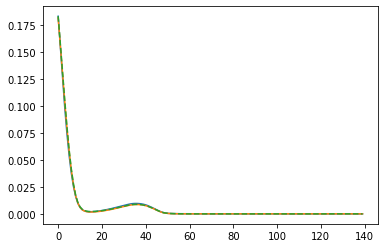

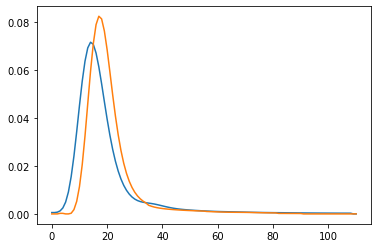

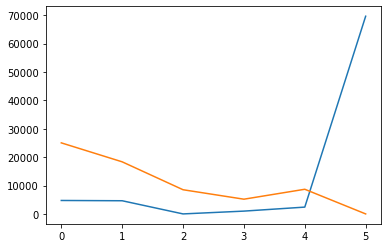

integral_array = [[ 4736.43778979 25031.41506641]
 [ 4638.27592167 18350.80055169]
 [    0.          8518.84589202]
 [  988.05434701  5186.89571206]
 [ 2399.28458732  8684.57568702]
 [69638.02893539     0.        ]]
----- new PARAFAC decomposition with iteration offset -1 -----
new data tensor with boundaries (1280, 1389) and shape(5,) built from ['2-chlorotoluene'].
PARAFAC data tensor has boundaries in the time axis of (1280, 1389).
Compound used for PARAFAC data tensor: 2-chlorotoluene


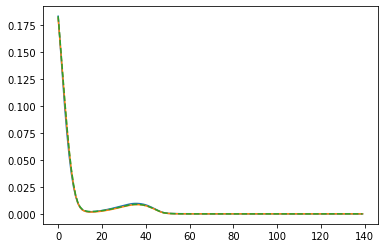

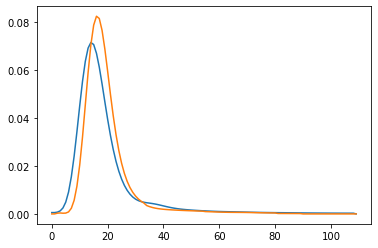

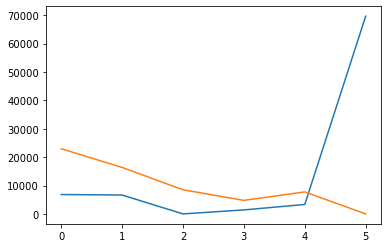

integral_array = [[ 6835.89830846 22950.67936077]
 [ 6647.68051032 16367.80909016]
 [    0.          8499.20783798]
 [ 1410.94460568  4766.06099508]
 [ 3330.14984277  7755.23212368]
 [69626.97735004     0.        ]]
----- new PARAFAC decomposition with iteration offset 0 -----
new data tensor with boundaries (1280, 1388) and shape(5,) built from ['2-chlorotoluene'].
PARAFAC data tensor has boundaries in the time axis of (1280, 1388).
Compound used for PARAFAC data tensor: 2-chlorotoluene


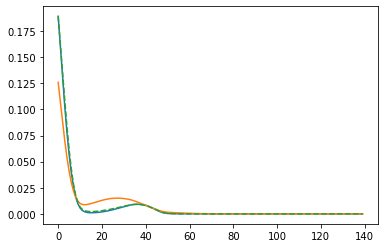

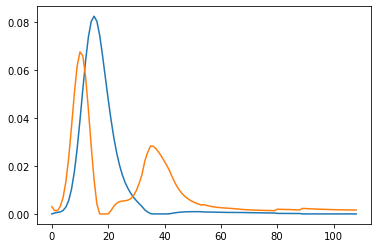

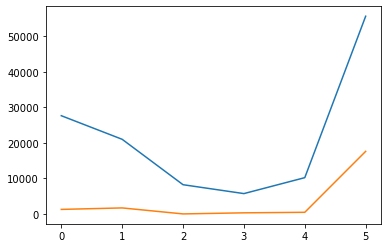

integral_array = [[27649.49827605  1269.94046738]
 [21005.46559701  1688.08135084]
 [ 8223.76515849     0.        ]
 [ 5720.81590791   306.28323466]
 [10210.25363266   455.21545041]
 [55651.29679223 17610.93978574]]
----- new PARAFAC decomposition with iteration offset 1 -----
new data tensor with boundaries (1280, 1389) and shape(5,) built from ['2-chlorotoluene'].
PARAFAC data tensor has boundaries in the time axis of (1280, 1389).
Compound used for PARAFAC data tensor: 2-chlorotoluene


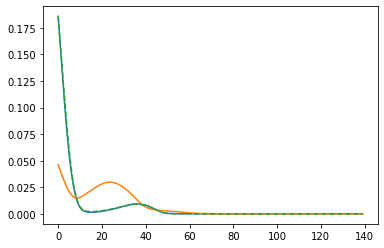

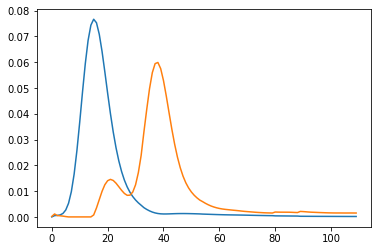

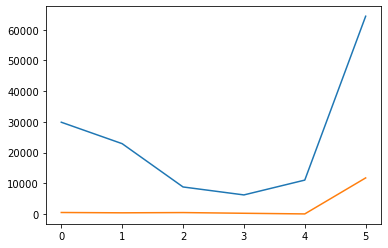

integral_array = [[29864.18846216   462.88001111]
 [22881.30039435   359.08670606]
 [ 8780.52186461   438.69584466]
 [ 6187.42451946   211.10789868]
 [11016.71288757     0.        ]
 [64388.8325628  11728.52775335]]
----- new PARAFAC decomposition with iteration offset 2 -----
new data tensor with boundaries (1280, 1390) and shape(5,) built from ['2-chlorotoluene'].
PARAFAC data tensor has boundaries in the time axis of (1280, 1390).
Compound used for PARAFAC data tensor: 2-chlorotoluene


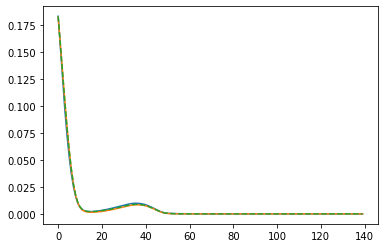

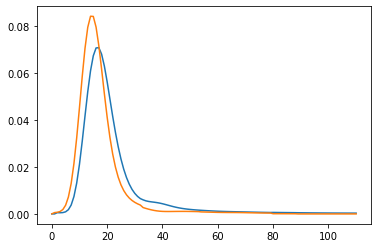

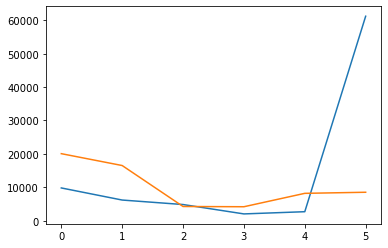

integral_array = [[ 9797.75256568 20061.94585275]
 [ 6176.34284486 16510.76820474]
 [ 4830.49090486  4244.4262197 ]
 [ 2021.38731793  4169.94848122]
 [ 2684.42609599  8182.71464671]
 [61210.41833314  8508.72654268]]
----- new PARAFAC decomposition with iteration offset 3 -----
new data tensor with boundaries (1280, 1391) and shape(5,) built from ['2-chlorotoluene'].
PARAFAC data tensor has boundaries in the time axis of (1280, 1391).
Compound used for PARAFAC data tensor: 2-chlorotoluene


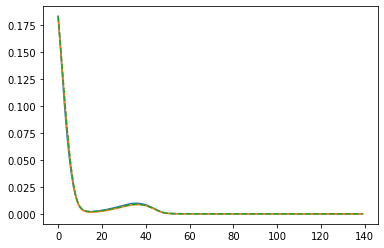

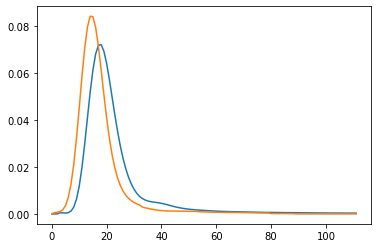

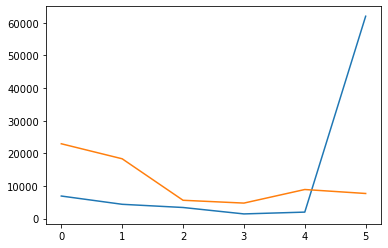

integral_array = [[ 6915.80517414 22928.24898711]
 [ 4384.11550411 18329.23073266]
 [ 3404.81537333  5615.33608377]
 [ 1436.97165676  4753.27075909]
 [ 1988.98193387  8912.80279028]
 [61996.71806196  7697.2463408 ]]


In [32]:
for iter_offset in [-3, -2, -1, 0, 1, 2, 3]:
    parafac(impure_peak, campaign.quali_comp_db, iter_offset, show_parafac_analytics=True)

In [17]:
for peak in campaign.chroms[0].peaks:
    print(peak.dataset.time[peak.maximum])
    print(peak.pure)
    print(peak.idx)


1.0049983338887039
True
1
2.004665111629457
True
2
2.6871042985671445
True
-3
2.6871042985671445
False
3
3.4521826057980673
True
4
3.604131956014662
True
5
3.7507497500833056
True
6


In [16]:
for peak in campaign.peak_db:
    if peak.idx < 0:
        print(peak.compound_id)
        print(peak.idx)

unknown_22
-1
unknown_22
-3
tetralin
-8
tetralin
-6
2-chlorotuluene
-1


In [28]:
import os

def countlines(start, lines=0, header=True, begin_start=None):
    if header:
        print('{:>10} |{:>10} | {:<20}'.format('ADDED', 'TOTAL', 'FILE'))
        print('{:->11}|{:->11}|{:->20}'.format('', '', ''))

    for thing in os.listdir(start):
        thing = os.path.join(start, thing)
        if os.path.isfile(thing):
            if thing.endswith('.py'):
                with open(thing, 'r') as f:
                    newlines = f.readlines()
                    newlines = list(filter(lambda l : not l.startswith("#"), newlines))
                    newlines = list(filter(lambda l : l.replace(" ", "")  not in ['\n', '\r\n'], newlines))
                    newlines = len(newlines)
                    lines += newlines

                    if begin_start is not None:
                        reldir_of_thing = '.' + thing.replace(begin_start, '')
                    else:
                        reldir_of_thing = '.' + thing.replace(start, '')

                    print('{:>10} |{:>10} | {:<20}'.format(
                            newlines, lines, reldir_of_thing))


    for thing in os.listdir(start):
        thing = os.path.join(start, thing)
        if os.path.isdir(thing):
            lines = countlines(thing, lines, header=False, begin_start=start)

    return lines

In [29]:
countlines(r'/Users/haascp/Documents/GitHub/mocca/src/mocca')

     ADDED |     TOTAL | FILE                
-----------|-----------|--------------------
        14 |        14 | ./__init__.py       
        76 |        90 | ./visualization/parafac_plots.py
         0 |        90 | ./visualization/__init__.py
        91 |       181 | ./visualization/basic_plots.py
        12 |       193 | ./visualization/utils.py
        66 |       259 | ./visualization/results_plot.py
        79 |       338 | ./visualization/calibration_plots.py
       113 |       451 | ./dad_data/models.py
         0 |       451 | ./dad_data/__init__.py
        73 |       524 | ./dad_data/utils.py 
        64 |       588 | ./dad_data/process_gradientdata.py
       115 |       703 | ./dad_data/process_funcs.py
         0 |       703 | ./apis/__init__.py  
        59 |       762 | ./apis/chemstation_api.py
        51 |       813 | ./apis/labsolutions_api.py
       122 |       935 | ./chromatogram/correct.py
         0 |       935 | ./chromatogram/__init__.py
        51 |       986

3537

In [38]:
import numpy as np
a = np.ndarray([[[1,2,3,4,5], [2,2,3,4,5], [3,2,3,4,5]], [[4,2,3,4,5], [5,2,3,4,5], [6,2,3,4,5]]])
a[:, 2]

TypeError: 'list' object cannot be interpreted as an integer

In [19]:
template_peak = campaign.chroms[0].peaks[1]

In [20]:
peak = CorrectedPeak(left=template_peak.left,
                         right=template_peak.right,
                         maximum=template_peak.maximum,
                         dataset=template_peak.dataset,
                         idx=template_peak.idx,
                         saturation=template_peak.saturation,
                         pure=template_peak.pure,
                         integral=template_peak.integral,
                         offset=template_peak.offset,
                         istd=template_peak.istd)

In [21]:
peak

CorrectedPeak(left=737, right=780, maximum=751, dataset=CompoundData(hplc_system_tag='labsolutions', experiment=Experiment(path='/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_4.txt', compound=None, istd=[InternalStandard(key='tetralin', conc=0.06094)], gradient=False, processed=True), path='/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_4.txt', data=array([[0.60540834, 0.60062571, 0.56764307, ..., 0.11308614, 0.10714952,
        0.0958129 ],
       [0.53313182, 0.5290444 , 0.49815698, ..., 0.13909139, 0.13275872,
        0.12262604],
       [0.46866425, 0.46518778, 0.43811131, ..., 0.16722611, 0.15765711,
        0.14848811],
       ...,
       [0.00985935, 0.00982639, 0.00819342, ..., 0.00556906, 0.00459204,
        0.00421501],
       [0.00773878, 0.00772346, 0.00750815, ..., 0.00479489, 0.00421391,
        0.00543293],
       [0.        , 0.     

In [19]:
def overlap(peak, component):
        return component.left <= peak.left <= component.right \
            or peak.left <= component.left <= peak.right

In [20]:
for comp in campaign.quali_comp_db:
    print(comp.compound_id, comp.left, comp.right)
    print(overlap(peak, comp))

tetralin 1394 1459
False
2-chlorotuluene 1283 1326
True
o-tolunitrile 994 1091
False


In [22]:
parafac_peaks = get_parafac_peaks(peak, campaign.quali_comp_db, show_parafac_analytics = True)

In [39]:
import numpy as np
from mocca.peak.utils import get_peak_data

In [40]:
left = parafac_peaks[0].left
right = parafac_peaks[0].right

In [42]:
np.max(get_peak_data(parafac_peaks[0]))

57.22552730058658

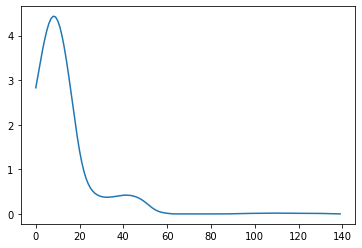

In [52]:
plt.plot(get_peak_data(parafac_peaks[0])[:, 50])

In [23]:
peak.idx

2

In [24]:
parafac_peaks[0].idx

-2

In [231]:
parafac_tensor = (test[0], test[1], test[2])

[autoreload of mocca.peak.resolve_impure failed: Traceback (most recent call last):
  File "/Users/haascp/opt/anaconda3/envs/mocca-dev/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/haascp/opt/anaconda3/envs/mocca-dev/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/haascp/opt/anaconda3/envs/mocca-dev/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/haascp/opt/anaconda3/envs/mocca-dev/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen 

In [233]:
parafac_comp_tensors = []
for i in range(2):
    parafac_comp_tensor = (parafac_tensor[0][:, i],
                           parafac_tensor[1][:, i],
                           parafac_tensor[2][:, i])
    parafac_comp_tensors.append(parafac_comp_tensor)

In [248]:
parafac_comp_tensors[0][0].size

140

In [80]:
for peak in campaign.chroms[0].peaks:
    display(peak.maximum)
    display(peak.compound_id)
    display(peak.integral)
    display(peak.concentration)

376

'unknown_1'

206550.8402845089

None

751

'unknown_2'

16187.308089379052

None

1007

None

108227.6753674092

None

1294

'2-chlorotuluene'

15995.194547856316

0.03258938909374124

1351

'unknown_3'

310478.6081232501

None

1406

'tetralin'

45524.56221006884

0.030565292181505214

In [35]:
for chrom in campaign.compound_chroms:
    display(chrom.dataset.path)
    for peak in chrom.peaks:
        display(peak.compound_id)
        display(peak.integral)
        #display(peak.concentration)
        display(peak.istd)

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_96.txt'

'2-chlorotuluene'

10618.060848096951

[]

'tetralin'

90765.2642286953

[]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_88.txt'

'2-chlorotuluene'

29082.561621718694

[IstdPeak(maximum=1407, integral=37415.788129257555, offset=1, compound_id='tetralin', concentration=0.06094)]

'tetralin'

37415.788129257555

[IstdPeak(maximum=1407, integral=37415.788129257555, offset=1, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_89.txt'

'2-chlorotuluene'

22403.533720771888

[IstdPeak(maximum=1406, integral=40018.91508806365, offset=0, compound_id='tetralin', concentration=0.06094)]

'tetralin'

40018.91508806365

[IstdPeak(maximum=1406, integral=40018.91508806365, offset=0, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_92.txt'

'o-tolunitrile'

203579.565272476

[IstdPeak(maximum=1406, integral=39027.10437635546, offset=0, compound_id='tetralin', concentration=0.06094)]

'tetralin'

39027.10437635546

[IstdPeak(maximum=1406, integral=39027.10437635546, offset=0, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_93.txt'

'o-tolunitrile'

123388.0305363853

[IstdPeak(maximum=1408, integral=32509.528803783243, offset=2, compound_id='tetralin', concentration=0.06094)]

'tetralin'

32509.528803783243

[IstdPeak(maximum=1408, integral=32509.528803783243, offset=2, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_94.txt'

'o-tolunitrile'

101291.93802706029

[IstdPeak(maximum=1405, integral=39231.976970444244, offset=-1, compound_id='tetralin', concentration=0.06094)]

'tetralin'

39231.976970444244

[IstdPeak(maximum=1405, integral=39231.976970444244, offset=-1, compound_id='tetralin', concentration=0.06094)]

In [177]:
for comp in campaign.quali_comp_db.items:
    display(comp.compound_id)
    display(comp.maximum)
    display(len(comp.created_from))


'tetralin'

1406

7

'2-chlorotuluene'

1295

3

'o-tolunitrile'

1007

3

In [48]:
for comp in campaign.quant_comp_db.items:
    display(comp.compound_id)
    display(comp.calib_factors)
    display(comp.calib_data)
    display(comp.calib_scores)
    display(len(comp.created_from))

'tetralin'

{'absolute': 1489420.15472096}

{'absolute': [(0.06094, 90765.2642286953)]}

{'absolute': nan}

1

'2-chlorotuluene'

{'absolute': 490809.8921967266, 'tetralin': 0.7806230737067894}

{'absolute': [(0.0603, 29082.561621718694), (0.04422, 22403.533720771888)],
 'tetralin': [(0.0603, 0.04736747223137285), (0.04422, 0.03411565110996862)]}

{'absolute': 0.9662250880730451, 'tetralin': 0.9971485738520937}

2

'o-tolunitrile'

{'absolute': 3237864.687574665, 'tetralin': 5.318045099264461}

{'absolute': [(0.05955, 203579.565272476),
  (0.04367, 123388.0305363853),
  (0.029775, 101291.93802706029)],
 'tetralin': [(0.05955, 0.3178851955827124),
  (0.04367, 0.23129423456953574),
  (0.029775, 0.15733927219674235)]}

{'absolute': 0.9199017630682809, 'tetralin': 0.9997418952808681}

3

In [65]:
for chrom in campaign.bad_chroms:
    display(chrom.dataset.path)

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_90.txt'

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_91.txt'

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_95.txt'

In [25]:
test = ((1, 2), (2, 4), (3, 6), (4, 8))

In [26]:
for i in zip(*test):
    print(i)

(1, 2, 3, 4)
(2, 4, 6, 8)


In [27]:
reaction_folders[81]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_85.txt'

In [22]:
stats = campaign.quant_comp_db.items[2].calib_scores
max(stats, key=lambda key: stats[key])

'tetralin'

In [24]:
"a" is 'a'

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/c_/gt8zcwrn18s1dhd756dg2srw0000gn/T/ipykernel_1926/4094855256.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  "a" is 'a'


True

In [64]:
reaction_folders[0]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_4.txt'

In [24]:
class Vehicle:
    pass

class Truck(Vehicle):
    pass

In [26]:
isinstance(Truck(), Vehicle)    # returns True

True